In [6]:
import pandas as pd
import matplotlib.pyplot as plt

data_path_ludnosc = "../ludnosc.csv"
data_path_gminy = "../gminy.csv"
df_ludnosc = pd.read_csv(data_path_ludnosc, sep=";", thousands=',')
df_gminy = pd.read_csv(data_path_gminy, sep=";", decimal=',')

/Users/kozlovvski/.pyenv/versions/3.9.7/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df_bezrobocie = df_gminy[(df_gminy.Kategoria == 'Bezrobocie')][['Nazwa', 'Kod', 'Rok', 'Zmienna', 'Wartosc']]

## Struktura bezrobocia w Polsce na przestrzeni lat

In [8]:
def create_frequency_df(src_df):
  temp_df = pd.DataFrame()
  temp_df['Rok'] = src_df.Rok.unique()
  temp_df.set_index('Rok', inplace=True)
  p_k = src_df[src_df['Zmienna'] == 'kobiety'].set_index('Rok')['Wartosc'] / 100
  p_o = src_df[src_df['Zmienna'] == 'ogółem'].set_index('Rok')['Wartosc'] / 100
  l_k = df_gminy[(df_gminy['Kategoria'] == 'Kobiety wg grup wieku') & (df_gminy['Zmienna'] == 'ogółem') & (df_gminy['Kod'] == src_df['Kod'].unique()[0])].set_index('Rok')['Wartosc']
  l_m = df_gminy[(df_gminy['Kategoria'] == 'Mężczyźni wg grup wieku') & (df_gminy['Zmienna'] == 'ogółem') & (df_gminy['Kod'] == src_df['Kod'].unique()[0])].set_index('Rok')['Wartosc']
  temp_df['udział kobiet w bezrobociu'] = p_k * l_k / (p_o * (l_k + l_m))
  temp_df['udział mężczyzn w bezrobociu'] = 1 - temp_df['udział kobiet w bezrobociu']

  return temp_df

#### 1. Wykres struktury bezrobocia w Polsce na przestrzeni lat

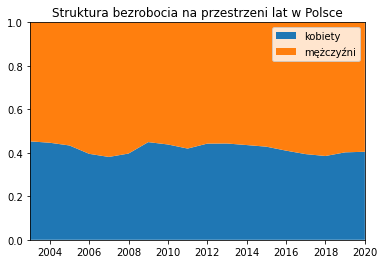

In [26]:
df_bezrobocie_polska = create_frequency_df(df_bezrobocie[df_bezrobocie['Nazwa'] == "POLSKA"])

plt.stackplot(df_bezrobocie_polska.index, df_bezrobocie_polska['udział mężczyzn w bezrobociu'], df_bezrobocie_polska['udział kobiet w bezrobociu'], labels=['kobiety', 'mężczyźni'])
plt.title(f'Struktura bezrobocia na przestrzeni lat w Polsce')
plt.legend(loc='best')
plt.margins(0,0)
plt.show()

#### 2. Gminy z największą zmianą w strukturze bezrobocia
Dla każdego regionu liczymy odchylenie standardowe z różnicy pomiędzy procentem bezrobotnych kobiet a procentem bezrobotnych mężczyzn na przestrzeni lat 
To pozwoli nam w miarę dokładnie oszacować gminy z największą zmiennością w strukturze bezrobocia
Jeszcze lepszą metodą byłoby wywołanie metody `create_frequency_df` dla każdej z gmin, gdyż policzylibyśmy faktyczny stosunek liczby bezrobotnych kobiet do liczby bezrobotnych mężczyzn
Niemniej jednak taka pętla nie wykonała się w 30 minut, więc skorzystamy z pierwszej metody

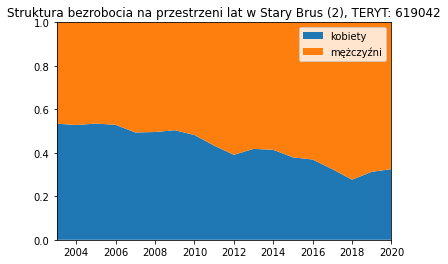

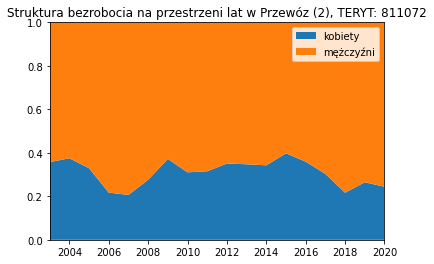

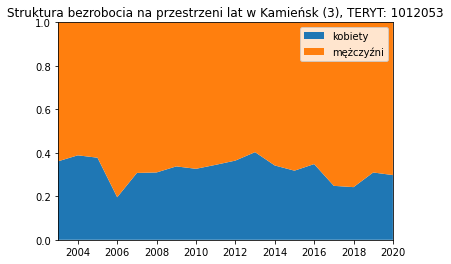

In [29]:
stds_list = list()
groups = df_bezrobocie.groupby(['Kod'])

for name, group in groups: 
  p_k = group[group['Zmienna'] == 'kobiety'].set_index('Rok')['Wartosc']
  p_m = group[group['Zmienna'] == 'mężczyźni'].set_index('Rok')['Wartosc']
  std = (p_k - p_m).std()
  temp_serie = {'Kod': name, 'std__udział kobiet w bezrobociu': std}
  stds_list.append(temp_serie)

stds_list.sort(key=lambda x: x['std__udział kobiet w bezrobociu'], reverse=True)

for i in range(3):
  code = stds_list[i]['Kod']
  group = groups.get_group(code)
  temp_df = create_frequency_df(group)
  name = df_bezrobocie[df_bezrobocie['Kod'] == code]['Nazwa'].unique()[0]

  plt.stackplot(temp_df.index, temp_df['udział mężczyzn w bezrobociu'], temp_df['udział kobiet w bezrobociu'], labels=['kobiety', 'mężczyźni'])
  plt.legend(loc='best')
  plt.title(f'Struktura bezrobocia na przestrzeni lat w {name}, TERYT: {code}')
  plt.margins(0,0)
  plt.show()